<a href="https://colab.research.google.com/github/compressed-sensing/algorithms/blob/main/notebooks/TV_Condat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Reference](https://lcondat.github.io/software.html)

In [ ]:
%%shell
wget https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks.txt
wget https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks_noisy.txt

--2023-04-06 13:04:06--  https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks.txt
Resolving eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)... 128.238.64.104
Connecting to eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)|128.238.64.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352 (4.2K) [text/plain]
Saving to: ‘blocks.txt’

blocks.txt          100%[===================>]   4.25K  --.-KB/s    in 0s      

2023-04-06 13:04:06 (152 MB/s) - ‘blocks.txt’ saved [4352/4352]

--2023-04-06 13:04:06--  https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/TVDmm/TVD_software/blocks_noisy.txt
Resolving eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)... 128.238.64.104
Connecting to eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)|128.238.64.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352 (4.2K) [text/plain]
Saving to: ‘blocks_noisy.txt’

blocks_noisy.txt    100%[===============

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, spdiags, diags, csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.fftpack import fft, ifft
import time
import cv2
import urllib.request
from skimage.metrics import peak_signal_noise_ratio as PSNR

In [ ]:
def TV_Condat_v2(y, lam):
    start = time.time()
    N = len(y)
    if N <= 1:
        return y
    x = np.zeros_like(y)
    cost = np.zeros(N)
    indstart_low = np.zeros(N, dtype=int)
    indstart_up = np.zeros(N, dtype=int)
    j_low = j_up = jseg = indjseg = 0
    indstart_low[0] = indstart_up[0] = 0
    x_low_first = y[0] - lam
    x_up_first = y[0] + lam
    x_low_curr = x_low_first
    x_up_curr = x_up_first
    cost[0] = 0.5 * np.sum(np.abs(x - y)**2) + lam * np.sum(np.abs(np.diff(x)))
    for i in range(1, N-1):
        if y[i] >= x_low_curr:
            if y[i] <= x_up_curr:
                x_up_curr = x_up_curr + (y[i]-x_up_curr)/(i-indstart_up[j_up]+1)
                x[indjseg] = x_up_first
                while j_up > jseg and x_up_curr <= x[indstart_up[j_up-1]]:
                    j_up -= 1
                    x_up_curr = x[indstart_up[j_up]] + \
                                (x_up_curr - x[indstart_up[j_up]]) * \
                                ((i-indstart_up[j_up+1]+1)/(i-indstart_up[j_up]+1))
                if j_up == jseg:
                    while x_up_curr <= x_low_first and jseg < j_low:
                        jseg += 1
                        x[indjseg:indstart_low[jseg]-1] = x_low_first
                        x_up_curr = x_up_curr + (x_up_curr - x_low_first) * \
                                    ((indstart_low[jseg]-indjseg)/(i-indstart_low[jseg]+1))
                        indjseg = indstart_low[jseg]
                        x_low_first = x[indjseg]
                    x_up_first = x_up_curr
                    j_up = jseg
                    indstart_up[jseg] = indjseg
                else:
                    x[indstart_up[j_up]] = x_up_curr
            else:
                j_up += 1
                indstart_up[j_up] = i
                x[i] = y[i]
                x_up_curr = x[i]
            x_low_curr = x_low_curr + (y[i]-x_low_curr)/(i-indstart_low[j_low]+1)
            x[indjseg] = x_low_first
            while j_low > jseg and x_low_curr >= x[indstart_low[j_low-1]]:
                j_low -= 1
                x_low_curr = x[indstart_low[j_low]] + \
                             (x_low_curr - x[indstart_low[j_low]]) * \
                             ((i-indstart_low[j_low+1]+1)/(i-indstart_low[j_low]+1))
            if j_low == jseg:
                while x_low_curr >= x_up_first and jseg < j_up:
                    jseg += 1
                    x[indjseg:indstart_up[jseg]-1] = x_up_first
                    x_low_curr = x_low_curr + (x_low_curr - x_up_first) * \
                                 ((indstart_up[jseg]-indjseg)/(i-indstart_up[jseg]+1))
                    indjseg = indstart_up[jseg]
                    x_up_first = x[indjseg]
                x_low_first = x_low_curr
                j_low = jseg
                indstart_low[jseg] = indjseg
                if indjseg==i:
                    x_low_first=x_up_first-2*lam
            else:
                x[indstart_low[j_low]] = x_low_curr
        else:
            j_low = j_low + 1
            indstart_low[j_low] = i
            x[i] = y[i]
            x_low_curr = x[i]

            # fusion of x_up to keep it nondecreasing
            x_up_curr = x_up_curr + (y[i] - x_up_curr) / (i - indstart_up[j_up] + 1)
            x[indjseg] = x_up_first

            while j_up > jseg and x_up_curr <= x[indstart_up[j_up - 1]]:
                j_up = j_up - 1
                x_up_curr = x[indstart_up[j_up]] + (x_up_curr - x[indstart_up[j_up]]) * \
                    ((i - indstart_up[j_up + 1] + 1) / (i - indstart_up[j_up] + 1))
            if j_up == jseg:
                # a jump in x downwards is possible
                while x_up_curr <= x_low_first and jseg < j_low:
                    # validation of segments of x_low in x
                    jseg += 1
                    x[indjseg:indstart_low[jseg]-1] = x_low_first
                    x_up_curr = x_up_curr + (x_up_curr - x_low_first) * \
                        ((indstart_low[jseg] - indjseg) / (i - indstart_low[jseg] + 1))
                    indjseg = indstart_low[jseg]
                    x_low_first = x[indjseg]
                x_up_first = x_up_curr
                j_up = jseg
                indstart_up[jseg] = indjseg
                if indjseg == i:
                    # this part is not mandatory, it is a kind of reset to increase numerical robustness.
                    x_up_first = x_low_first + 2 * lam
            else:
                x[indstart_up[j_up]] = x_up_curr
        cost[i] = 0.5 * np.sum(np.abs(x - y)**2) + lam * np.sum(np.abs(np.diff(x)))
    i = N-1
    if y[i] + lam <= x_low_curr:
        # the segments of x_low are validated
        while jseg < j_low:
            jseg += 1
            x[indjseg:indstart_low[jseg]-1] = x_low_first
            indjseg = indstart_low[jseg]
            x_low_first = x[indjseg]
        x[indjseg:i-1] = x_low_first
        x[i] = y[i] + lam
    elif y[i] - lam >= x_up_curr:
        while jseg < j_up:
            jseg += 1
            x[indjseg:indstart_up[jseg]-1] = x_up_first
            indjseg = indstart_up[jseg]
            x_up_first = x[indjseg]
            
        x[indjseg:i-1] = x_up_first
        x[i] = y[i] - lam
    else:
        x_low_curr = x_low_curr + (y[i] + lam - x_low_curr) / (i - indstart_low[j_low] + 1)
        x[indjseg] = x_low_first
        while j_low > jseg and x_low_curr >= x[indstart_low[j_low - 1]]:
            j_low -= 1
            x_low_curr = x[indstart_low[j_low]] + (x_low_curr - x[indstart_low[j_low]]) * \
                ((i - indstart_low[j_low + 1] + 1) / (i - indstart_low[j_low] + 1))
        if j_low == jseg:
            if x_up_first >= x_low_curr:
                x[indjseg:i] = x_low_curr
            else:
                x_up_curr = x_up_curr + (y[i] - lam - x_up_curr) / (i - indstart_up[j_up] + 1)
                x[indjseg] = x_up_first
                while j_up > jseg and x_up_curr <= x[indstart_up[j_up - 1]]:
                    j_up = j_up - 1
                    x_up_curr = x[indstart_up[j_up]] + (x_up_curr - x[indstart_up[j_up]]) * \
                        ((i - indstart_up[j_up + 1] + 1) / (i - indstart_up[j_up] + 1))
                x[indstart_up[j_up]:i] = x_up_curr
                while jseg < j_up:
                    jseg = jseg + 1
                    x[indjseg:indstart_up[jseg] - 1] = x_up_first
                    indjseg = indstart_up[jseg]
                    x_up_first = x[indjseg]
        else:
            x[indstart_low[j_low]:i] = x_low_curr
            while jseg < j_low:
                jseg = jseg + 1
                x[indjseg:indstart_low[jseg]-1] = x_low_first
                indjseg = indstart_low[jseg]
                x_low_first = x[indjseg]
    cost[N-1] = 0.5 * np.sum(np.abs(x - y)**2) + lam * np.sum(np.abs(np.diff(x)))
    end = time.time()
    return x, cost, end-start



 


                



In [ ]:
s = np.loadtxt('blocks.txt')
y = np.loadtxt('blocks_noisy.txt')

In [ ]:
N = 256;                        # N : signal length
sigma = 0.5;                    # sigma : standard deviation of noise

Text(0.5, 1.0, 'noisy signal')

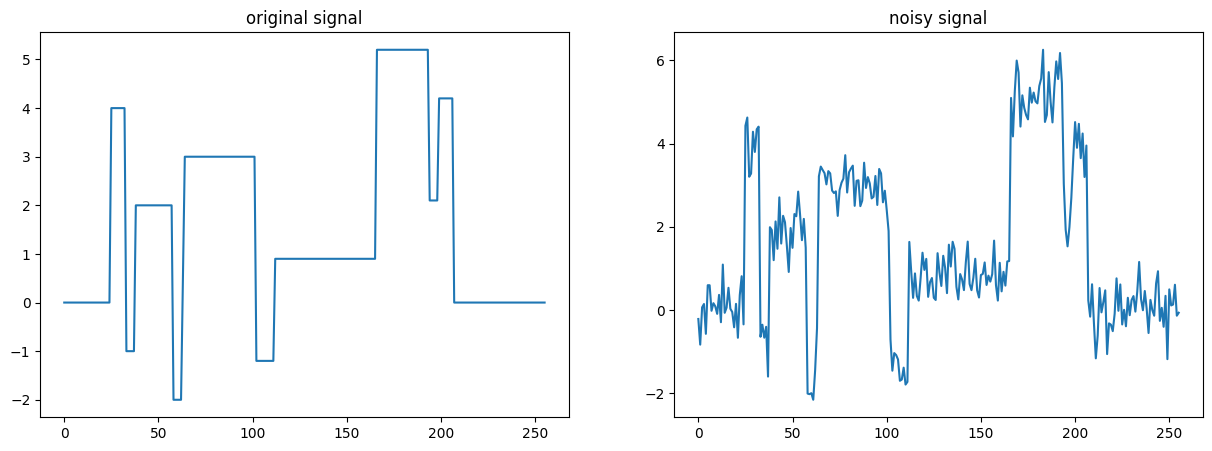

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(s)
axs[0].set_title("original signal")
axs[1].plot(y)
axs[1].set_title("noisy signal")

Time taken = 0.014072418212890625


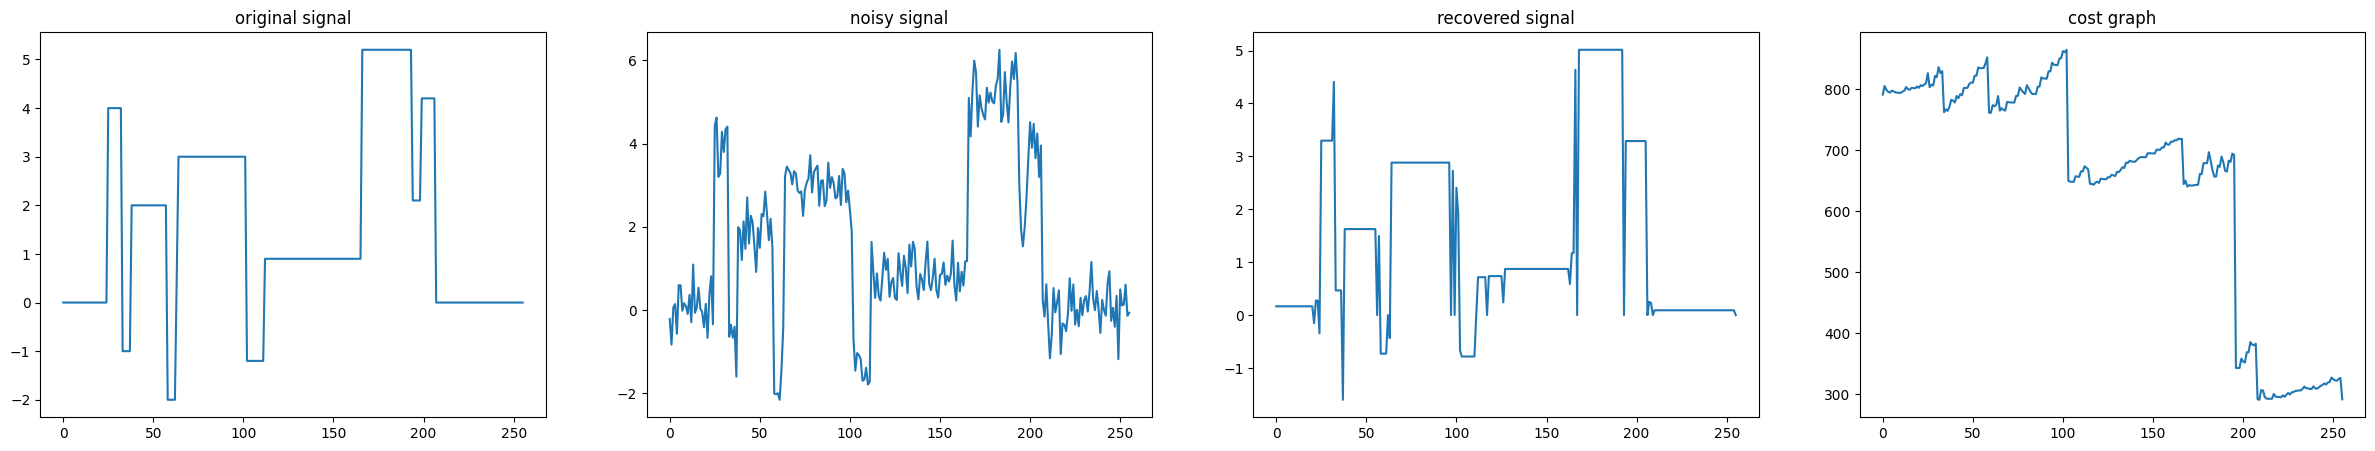

In [ ]:
lam = 3.
x_condat, cost_condat, time_taken = TV_Condat_v2(y, lam)
fig, axs = plt.subplots(1, 4, figsize=(30,5))
axs[0].plot(s)
axs[0].set_title("original signal")
axs[1].plot(y)
axs[1].set_title("noisy signal")
axs[2].plot(x_condat)
axs[2].set_title("recovered signal")
axs[3].plot(cost_condat)
axs[3].set_title("cost graph")
print(f"Time taken = {time_taken}")

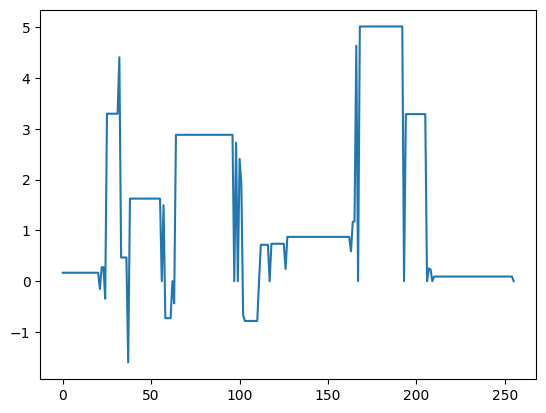

In [ ]:

plt.plot(x_condat)
# plt.axis('off')

In [ ]:
def awgn(image, sigma_n):
  noise = np.random.randn(image.shape[0], image.shape[1])*sigma_n 
  return image+noise

In [ ]:
def wrapper_condat(y):
  img_,_,__ = TV_Condat_v2(y, lam)
  return img_

In [ ]:
def ADRA_algorithm(img):
  rows_denoise = np.apply_along_axis(wrapper_condat, 0, img)
  # cols_denoise = np.apply_along_axis(wrapper_condat, 1, img)
  denoised = img.copy()
   # Compute the adaptive weights
  for i in range(0):
    row_var = np.apply_along_axis(np.var, axis=1, arr=rows_denoise, ddof=1)
    # col_var = np.apply_along_axis(np.var, axis=1, arr=cols_denoise, ddof=1)
    # row_weight = 1 / (1 + row_var)
    # col_weight = 1 / (1 + col_var)
    # denoised = (rows_denoise * col_weight) + (cols_denoise * row_weight)
    rows_denoise = np.apply_along_axis(wrapper_condat, 0, rows_denoise)
    # cols_denoise = np.apply_along_axis(wrapper_condat, 1, cols_denoise)
  return rows_denoise

In [ ]:
url = 'https://images.unsplash.com/photo-1664039591926-c1d776028289?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2022&q=80'
with urllib.request.urlopen(url) as url_response:
    img_array = np.asarray(bytearray(url_response.read()), dtype=np.uint8)
    img_gray = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

In [ ]:
img = cv2.resize(img_gray, (512,512), interpolation=cv2.INTER_AREA)
img = img/img.max()

In [ ]:
noisy_img = awgn(img, 0.1)

Text(0.5, 1.0, 'noisy signal')

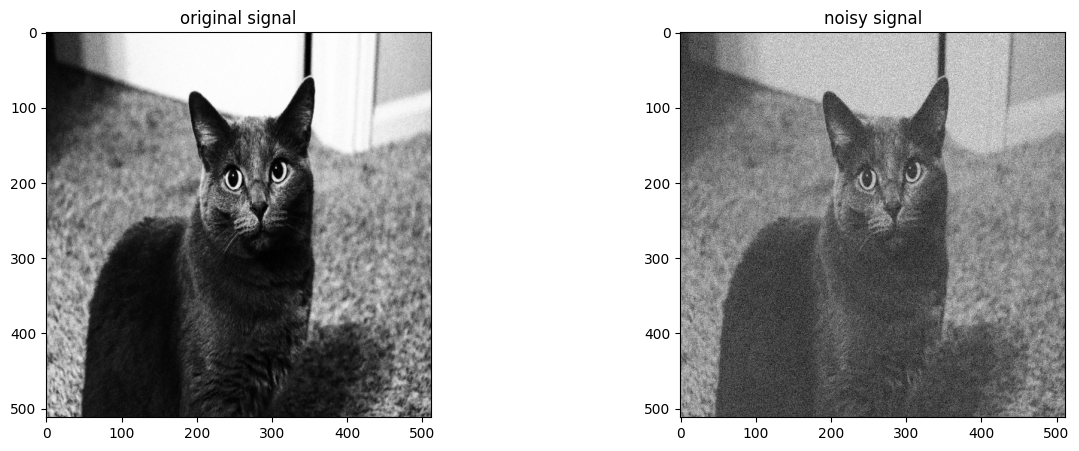

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title("original signal")
axs[1].imshow(noisy_img, cmap='gray')
axs[1].set_title("noisy signal")

In [ ]:
denoised_img = ADRA_algorithm(noisy_img)
fig, axs = plt.subplots(1, 4, figsize=(30,5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title("original signal")
axs[1].imshow(noisy_img, cmap='gray')
axs[1].set_title("noisy signal")
axs[2].imshow(denoised_img, cmap='gray')
axs[2].set_title("recovered signal")
# axs[3].plot(cost_condat)
# axs[3].set_title("cost graph")
# print(f"Time taken = {time_taken}")
print(f"noisy_img psnr = {PSNR(img.clip(0,1), noisy_img.clip(0,1))}")
print(f"noisy_img psnr = {PSNR(img.clip(0,1), denoised_img.clip(0,1))}")

KeyboardInterrupt: ignored

In [ ]:

def adra_1d(image):
    # Initialize variables
    x = np.copy(image)
    s = np.copy(image)
    gamma = 1.0
    
    # Denoise rows
    for j in range(image.shape[0]):
        x[j,:] = wrapper_condat(x[j,:])
    
    # Denoise columns
    for k in range(image.shape[1]):
        s[:,k] = wrapper_condat(s[:,k])
    
    # Update x using ADRA formula
        
    return s + x

In [ ]:
denoised_img = adra_1d(noisy_img)
fig, axs = plt.subplots(1, 4, figsize=(30,5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title("original signal")
axs[1].imshow(noisy_img, cmap='gray')
axs[1].set_title("noisy signal")
axs[2].imshow(denoised_img, cmap='gray')
axs[2].set_title("recovered signal")
# axs[3].plot(cost_condat)
# axs[3].set_title("cost graph")
# print(f"Time taken = {time_taken}")
print(f"noisy_img psnr = {PSNR(img.clip(0,1), noisy_img.clip(0,1))}")
print(f"noisy_img psnr = {PSNR(img.clip(0,1), denoised_img.clip(0,1))}")